# Transcription-Translation Model (for checking the code)

In [1]:
# go to the parent folder
import os
# os.chdir("..")

import numpy as np
import pandas as pd
import time

# Our package
from CRN_Simulation.CRN import CRN
from CRN_Simulation_Inference.CRN_ContinuousTimeFiltering.CRNForContinuousTimeFiltering import CRNForContinuousTimeFiltering


In this example, we consider a transcription-translation model as follows:
\begin{align}
&\text{mRNA Transcription:} && \emptyset \to \text{mRNA} && \text{Propensity:} ~ k_1  \\
&\text{mRNA Degration:} &&\text{mRNA} \to \emptyset && \text{Propensity:} ~ k_2 X_\text{mRNA} \\
&\text{Translation:} &&\emptyset \to \text{Protein} && \text{Propensity:} ~ k_3 X_\text{mRNA} \\
&\text{Protein Degration:} &&\text{Protein} \to \emptyset && \text{Propensity:} ~ k_4 X_\text{protein} \\
\end{align}
Here, the mRNA is produced at a constant rate and translated into Proteins with a rate dependent on its abundance, while both species are degraded at a linear rate. Moreover, we assume that the Protein is fluorescent so that we can use a microscope to continuously observe its dynamics. We can then record all the information to our software as follows.

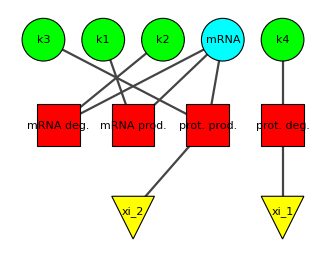

Number of subsystems: 2
-----------------------------------------------------
         xi_1  xi_2
Protein    -1     1
-----------------------------------------------------
Subsystem:  1
Involved parameters and species: ['k3', 'k1', 'k2', 'mRNA']
Unobservable reactions involved: ['mRNA deg.', 'mRNA prod.']
Observable reactions involved: ['prot. prod.']
Xi involved: ['xi_2']
Size of state space of this subsystem: 41261
-----------------------------------------------------
Subsystem:  2
Involved parameters and species: ['k4']
Unobservable reactions involved: []
Observable reactions involved: ['prot. deg.']
Xi involved: ['xi_1']
Size of state space of this subsystem: 11
-----------------------------------------------------


In [2]:
# The network structure
species_names = ['mRNA', 'Protein']
stoichiometric_matrix = [[1,-1, 0, 0], [0, 0, 1, -1]]
parameters_names = ['k1','k2','k3','k4']
reaction_names = ['mRNA prod.', 'mRNA deg.', 'prot. prod.', 'prot. deg.']
propensities = [
    lambda k1 : k1,
    lambda k2, mRNA : k2*mRNA,
    lambda k3, mRNA : k3*mRNA,
    lambda k4, Protein : k4*Protein
]

# The information related to filtering
observable_species = ['Protein']
range_of_species = \
    pd.DataFrame([[0, 30]], index=['mRNA'], columns=['min', 'max'])
range_of_parameters= \
    pd.DataFrame([[0.1, 2], [0.1, 2], [0.1, 2], [0.1, 2]],index=parameters_names,columns=['min', 'max'])
discretization_size_parameters = \
    pd.DataFrame([11, 11, 11, 11], index=parameters_names) #index=parameters_names

# construct the filtering class
CF = CRNForContinuousTimeFiltering(stoichiometric_matrix = stoichiometric_matrix,
                                   species_names = species_names,
                                   parameters_names = parameters_names,
                                   reaction_names = reaction_names,
                                   propensities = propensities,
                                   observable_species = observable_species,
                                   range_of_species = range_of_species,
                                   range_of_parameters = range_of_parameters,
                                   discretization_size_parameters = discretization_size_parameters
                                   )


CF.plot_decomposition(figsize=(5,5))  # the figsize might need to be tuned

Generate a simulation trajectory

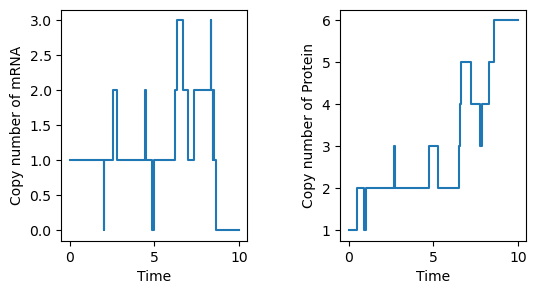

In [3]:
parameter_values = {'k1': 1.4,'k2': 1,'k3': 1,'k4': 0.2}
time_list, state_list = CF.SSA({'mRNA': 1, 'Protein': 1}, parameter_values, 0, 10)
# print('Time list:', time_list)
# print('State list:', state_list)
CF.plot_trajectories(time_list, state_list)

Solve the filtering problem

In [4]:
# set up the preparation step
start_time = time.time()
CF.set_up_preparations_for_filtering()
end_time = time.time()
execution_time = end_time - start_time
print("Time for preparing:", execution_time)

Time for preparing: 4.7876739501953125


In [5]:
# filtering

# extract the protein dynamics
Time_Y, Y_trajectory, Y_ordering = CF.extract_trajectory(time_list, state_list, CF.observable_species)

# create Initial distribution
Initial_distributions = [[]]
for i in range(1, CF.get_number_of_subsystem()+1):
    uniform_distribution = np.ones((CF.get_size_of_subsystems()[i], 1))/CF.get_size_of_subsystems()[i]
    Initial_distributions.append(uniform_distribution)

# filtering
start_time = time.time()
result =CF.filteringFFSP(
    Y_trajectory=Y_trajectory, 
    Y_ordering=Y_ordering, 
    Time_Y=Time_Y, 
    Initial_Distributions=Initial_distributions,
    tqdm_disable=False
)
end_time = time.time()
execution_time = end_time - start_time
print("Time for filtering:", execution_time)

Progress: 100%|██████████| 16/16 [00:13<00:00,  1.22 Observable_Jumps/s]

Time for filtering: 13.107983112335205


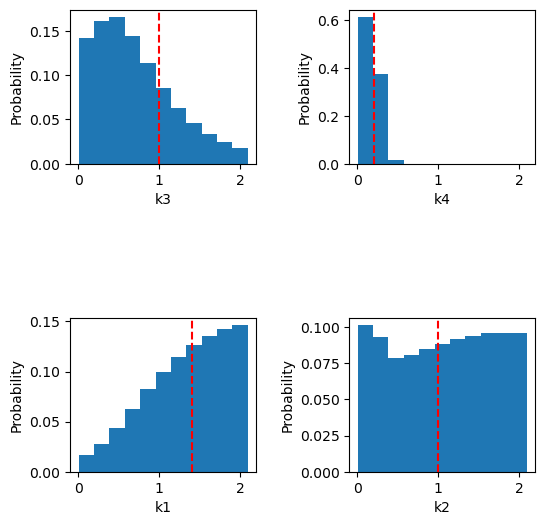

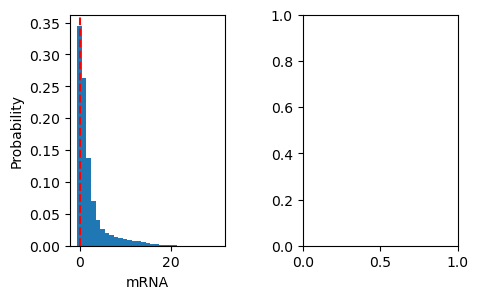

In [6]:
# plot the result
CF.plot_unknown_parameter_distribution_final_time(result, parameters_real_value = parameter_values)
CF.plot_hidden_species_distribution_final_time(result, {'mRNA': state_list[-1][0]})